<a href="https://colab.research.google.com/github/arbuz001/blog-code-snippets/blob/master/apac_deep_learning_validator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

import numpy as np
import pandas as pd
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, scale
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, Bidirectional, Dropout, Conv2D, Reshape,Activation
from matplotlib import pyplot as plt
from keras.layers import Conv1D, MaxPooling1D, MaxPooling2D, BatchNormalization, LeakyReLU
import tensorflow as tf
from keras.utils import normalize
from librosa.feature import mfcc
from keras import regularizers

Using TensorFlow backend.


In [0]:
csv_data_path = "/content/drive/My Drive/Colab Notebooks/more_samples_spoiled1.csv"
data = pd.read_csv(csv_data_path, sep=";", header=[0], index_col=0, encoding="ISO-8859-1")
csv_data_path1 = "/content/drive/My Drive/Colab Notebooks/more_samples_faults1.csv"
data1 = pd.read_csv(csv_data_path1, sep=";", header=[0], index_col=0, encoding="ISO-8859-1")

dataset, dataset1 = data.values, data1.values
X_train, y_train = dataset[:, 0:dataset.shape[1]], dataset1[:, 0:dataset.shape[1]]
X_train, y_train = np.transpose(X_train), np.transpose(y_train)

X_train = normalize(X_train, axis=-1, order=2)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

In [0]:
win_size = 25
X_new = np.zeros([X_train.shape[0], X_train.shape[1]//win_size, 25, 1], dtype=float)
y_n = np.zeros([y_train.shape[0], X_train.shape[1]//win_size], dtype=float)
    
for m in range(0, X_new.shape[0] - 1):
    for n in range(0, X_new.shape[1] - 1):
        temp = np.ndarray.flatten(X_train[m, (n * win_size):(n * win_size + win_size)])
        X_new[m, n, :] = mfcc(temp, n_mfcc=25)

for m in range(0, y_n.shape[0] - 1):
    for n in range(0, y_n.shape[1] - 1):
        y_n[m, n] = np.max(y_train[m, (n * win_size):(n * win_size + win_size)])

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 142, 23, 2048)     20480     
_________________________________________________________________
batch_normalization_1 (Batch (None, 142, 23, 2048)     8192      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 142, 11, 2048)     0         
_________________________________________________________________
reshape (Reshape)            (None, 142, 22528)        0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 142, 40)           3607840   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 142, 1)            41        
Total params: 3,63

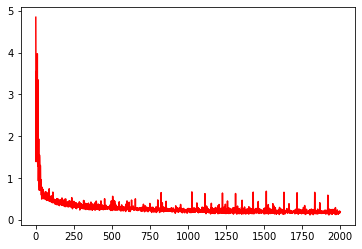

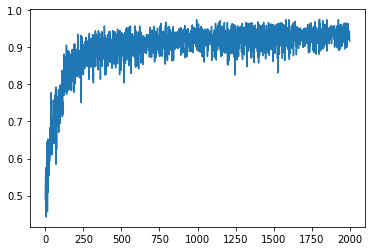

In [0]:
shp = y_train.shape[1]

def create_baseline():
    model = Sequential()
    model.add(Conv2D(2048, (3, 3), activation=LeakyReLU(alpha=0.1), input_shape=(144, 25, 1)))
    model.add(BatchNormalization(axis=-1, epsilon=0.00001))
    model.add(MaxPooling2D(pool_size=(1,2)))
    model.add(Reshape(target_shape=((142, -1)), name='reshape'))
    model.add(Bidirectional(LSTM(20, activation='relu', return_sequences=True)))
    model.add(TimeDistributed(Dense(1, activation='sigmoid')))
    sgd = optimizers.SGD(lr=0.0001, clipnorm=1.0)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    return model


def generator(X_train: np.ndarray, y_train: np.ndarray, shp: int, batch_size: int):
    batchCount = 0
    coeff = y_n.shape[1]//shp

    while True:
        for j in range(0, y_new.shape[0] - 1):
            for i in range(0, y_new.shape[1] - 1):
                y_new[j, i] = np.max(y_n[j, (i * coeff):(i * coeff + coeff)])
            batchCount += 1
            if batchCount >= batch_size:
                batchCount = 0
                yield X_new[(j - batch_size + 1): j+1, :, :], y_new[(j - batch_size + 1): j+1, :]


model = create_baseline()
shp = model.layers[-1].output.shape.dims[1]
y_new = np.zeros([y_n.shape[0], shp, 1], dtype=float)
model.summary()
log = model.fit_generator(generator(X_train, y_train, shp, 5), steps_per_epoch=1, epochs=2000)
plt.plot(log.history['loss'], label='Training', color='red')
plt.show()
plt.plot(log.history['acc'], label='Training')
plt.show()

In [0]:
y_hat = model.predict(X_new)

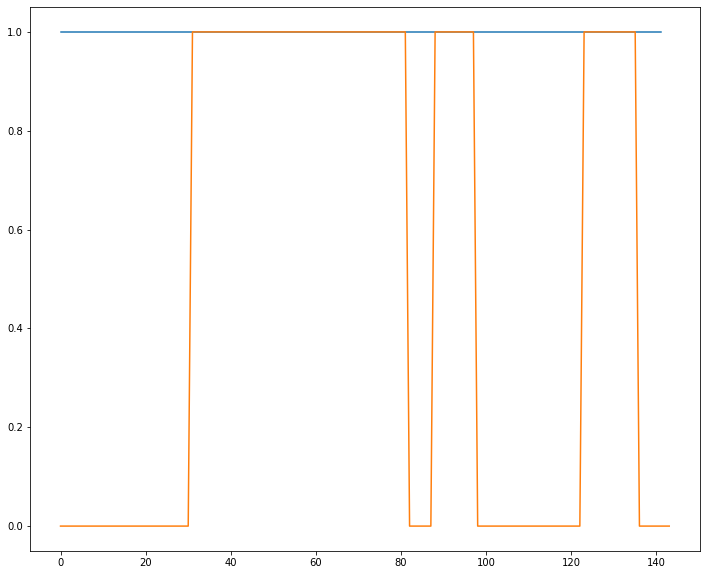

In [0]:
ts_num = 100
plt.figure(figsize=(12, 10))
plt.plot(y_hat[ts_num, :])
# plt.plot(y_new[ts_num, :])
# plt.plot(X_train[ts_num, ::25])

plt.plot(y_train[ts_num, ::25])